In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import string
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

train_df = pd.read_csv('/content/drive/MyDrive/spam.csv',encoding="ISO-8859-1",usecols=[0,1],names=['Spam','Text'])

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_df

,Spam,Text
0,v1,v2
1,ham,"Go until jurong point, crazy.. Available only ..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4,ham,U dun say so early hor... U c already then say...
...,...,...
5568,spam,This is the 2nd time we have tried 2 contact u...
5569,ham,Will Ì_ b going to esplanade fr home?
5570,ham,"Pity, * was in mood for that. So...any other s..."
5571,ham,The guy did some bitching but I acted like i'd...


Our task is to predict if the instances of email should be classified as spam or not. The first step will be to delete the first row from our dataset and then we will perform some preprocessing before choosing the model and fitting it.

In [ ]:
train_df.drop([0,0],inplace=True)

In [ ]:
train_df.reset_index(drop=True)

,Spam,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Now we need to replace the target values with 0, 1. Our next step will be to remove punctuation marks from the instances.

In [ ]:
train_df['Spam']=train_df['Spam'].replace(['ham','spam'],[0,1])

def remove_punctuation(text):
  clean_text=''.join([word for word in text if word not in string.punctuation])
  return clean_text

train_df['No punctuation']=train_df['Text'].apply(lambda x: remove_punctuation(x))

We will assume that the uppercase and lowercase letters are not important for our analysis, so we will transform all words to lowercase words. Then the instances will be tokenized.

In [ ]:
train_df['Lower letters']=train_df['No punctuation'].apply(lambda x: x.lower())
train_df['Tokenized text']=train_df['Lower letters'].apply(lambda x: nltk.word_tokenize(x))

All stopwords should be removed from the instances.

In [ ]:
stopwords=nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
  without_stopwords=[word for word in text if word not in stopwords]
  return without_stopwords
train_df['No stop words']=train_df['Tokenized text'].apply(lambda x: remove_stopwords(x))

As a part of normalisation, PorterStemmer will be used to transform the words into stems.

In [ ]:
stemmer=nltk.PorterStemmer()

def stems(text):
  stemmed_text=[stemmer.stem(word) for word in text]
  return stemmed_text

train_df['Stemmed text']=train_df['Tokenized text'].apply(lambda x: stems(x))

It is also necessary to lemmatize the words.

In [ ]:
lemmater=nltk.WordNetLemmatizer()

def lemmas(text):
  lemmatized_text=[lemmater.lemmatize(word) for word in text]
  return lemmatized_text

train_df['Lemmatized text']=train_df['Stemmed text'].apply(lambda x: lemmas(x))

In [ ]:
train_df

,Spam,Text,No punctuation,Lower letters,Tokenized text,No stop words,Stemmed text,Lemmatized text
1,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, until, jurong, point, crazi, avail, onli,...","[go, until, jurong, point, crazi, avail, onli,..."
2,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
3,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, in, 2, a, wkli, comp, to, win, f...","[free, entri, in, 2, a, wkli, comp, to, win, f..."
4,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, so, earli, hor, u, c, alreadi, t...","[u, dun, say, so, earli, hor, u, c, alreadi, t..."
5,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, i, dont, think, he, goe, to, usf, he, li...","[nah, i, dont, think, he, goe, to, usf, he, li..."
...,...,...,...,...,...,...,...,...
5568,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[thi, is, the, 2nd, time, we, have, tri, 2, co...","[thi, is, the, 2nd, time, we, have, tri, 2, co..."
5569,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,will ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[will, ì, b, go, to, esplanad, fr, home]","[will, ì, b, go, to, esplanad, fr, home]"
5570,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,pity was in mood for that soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, wa, in, mood, for, that, soani, other, ...","[piti, wa, in, mood, for, that, soani, other, ..."
5571,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,the guy did some bitching but i acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[the, guy, did, some, bitch, but, i, act, like...","[the, guy, did, some, bitch, but, i, act, like..."


From the preprocessed words we will create strings of spam and non-spam instances to visualize which words are the most frequent in each class of emails.
The same process will be applied to the training set.

In [ ]:
spam_string = list(train_df.loc[train_df['Spam']==1, 'Lemmatized text'].values)
spam_string = list(itertools.chain.from_iterable(spam_string))
spam_string = ' '.join(spam_string)
non_spam_string = list(train_df.loc[train_df['Spam']==0, 'Lemmatized text'].values)
non_spam_string = list(itertools.chain.from_iterable(non_spam_string))
non_spam_string = ' '.join(non_spam_string)

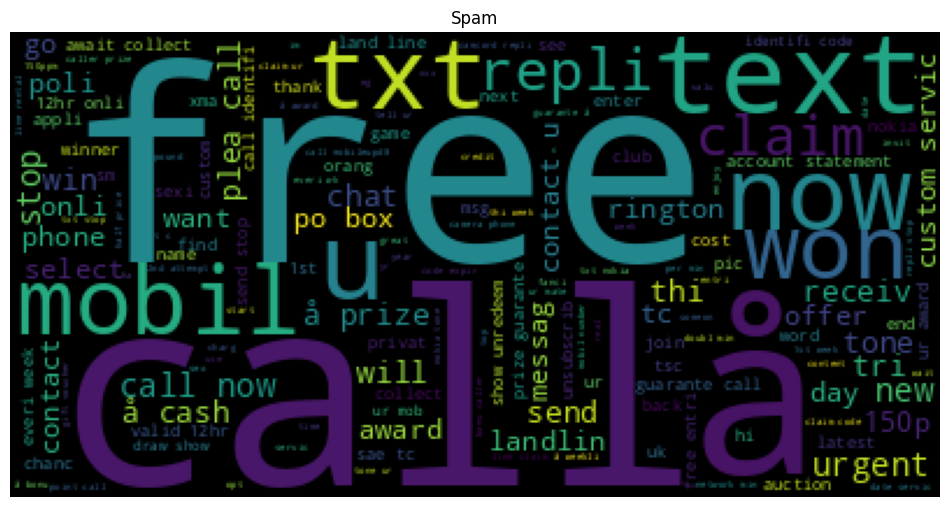

In [ ]:
wordcloud = WordCloud().generate(spam_string)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Spam')
plt.show()


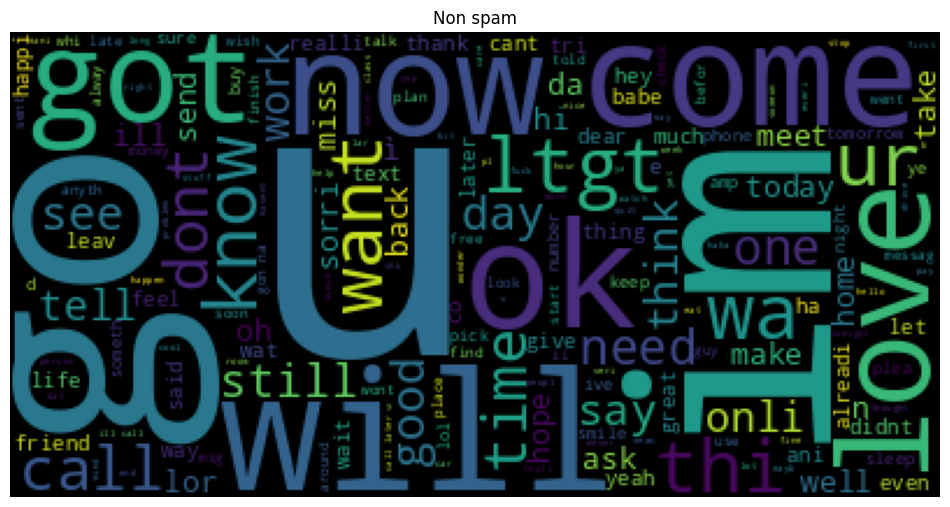

In [ ]:
wordcloud = WordCloud().generate(non_spam_string)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Non spam')
plt.show()

The preprocessed text will be

In [ ]:
train_df['Train text']=train_df['Lemmatized text'].apply(lambda x: ' '.join(x))

Before fitting the model the set should be vectorized.

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(2, 2), max_df=0.5, min_df=0.001, use_idf=True)
X = tfidf.fit_transform(train_df['Train text'])
y=train_df['Spam']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
model=RandomForestClassifier(n_estimators=300)
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
y_pred=model.predict(X_train)
print("Train results:", classification_report(y_train,y_pred))
y_pred_test=model.predict(X_test)
print("Test results:",classification_report(y_test,y_pred_test))

1.0
Train results:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3859
           1       1.00      1.00      1.00       598

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457

Test results:               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.80      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



The train results are very optimistic and when compared with the results on the test set, it can be observed that the model is overfitting. In the next version we will try to regularize our model to achieve better results.